# plot ekman pumping in easterlies experiment .. as a function of outcropping density class

In [155]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import datetime as dt
import xgcm

import xesmf
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [156]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:33085 Dashboard: /proxy/45205/status,Cluster Workers: 4 Cores: 8 Memory: 200.00 GiB


In [157]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [158]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

expt=control

In [159]:
variable='area_t'
area_t = cc.querying.getvar(expt,variable,master_session, n=-1)
area_t.load()
print(area_t.shape)

variable='xu_ocean'
xu_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
xu_ocean.load()
print(xu_ocean.shape)

variable='xt_ocean'
xt_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
xt_ocean.load()
print(xt_ocean.shape)

(2700, 3600)
(3600,)
(3600,)


In [160]:
#get mask of forcing region
#just do 1 year global to compare to obs
start_time='2150-01-01'
end_time='2150-01-31'
txc = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
txc = txc.sel(time=slice(start_time,end_time))
txc = txc.load()
txc

<xarray.DataArray 'tau_x' (time: 1, yu_ocean: 2700, xu_ocean: 3600)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time      (time) object 2150-01-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
Attributes:
    long_name:      i-directed wind stress forcing u-velocity
    units:          N/m^2
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  surface_downward_x_stress
    time_bounds:    <xarray.DataArray 'time_bounds' (time: 6, nv: 2)>\ndask.a...

In [161]:
# 15years of simulation:
start_time='2155-01-01'
end_time='2159-12-31'

#start_time='2150-01-01'
#end_time='2150-12-31'
#end_time='2164-12-31'
#end_time='2156-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-60.0) #-50.04-

In [162]:
#iso = xr.open_dataset('/home/561/pas561/gdv45/jnb/misc/Antarctic_isobath_1000m.nc')

In [163]:
#iso.y

In [164]:
#mask tx=0 region
#iso1mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht.yt_ocean>iso['y'])))
#iso1mask = ~xr.ufuncs.isnan(iso1mask).to_dataset(name='iso1mask')
#iso1area=area_t.where(iso1mask.iso1mask).sum(dim=('xt_ocean','yt_ocean')).compute()


In [165]:
#iso1mask

In [166]:
#z=iso1mask.to_array()
#z.plot()

In [167]:
# topography data for plotting:
ht = cc.querying.getvar(expt,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [168]:
#mask shelf regions
cstmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>300)))
cstmask = cstmask.where(~xr.ufuncs.isfinite(cstmask.where(ht.yt_ocean>-63)))
cstmask = ~xr.ufuncs.isnan(cstmask).to_dataset(name='cstmask')
cstarea=area_t.where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()


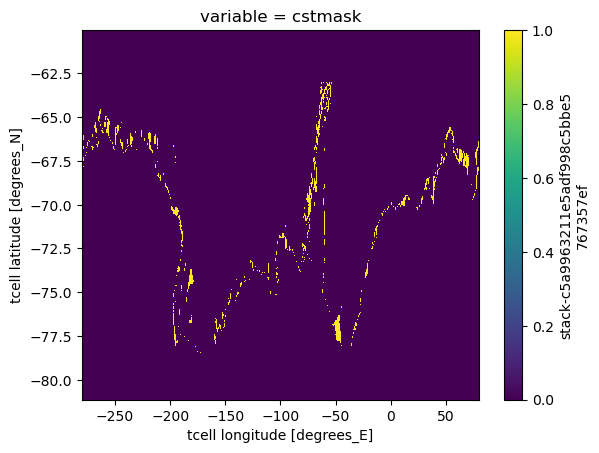

In [169]:
z=cstmask.to_array()
z.plot()

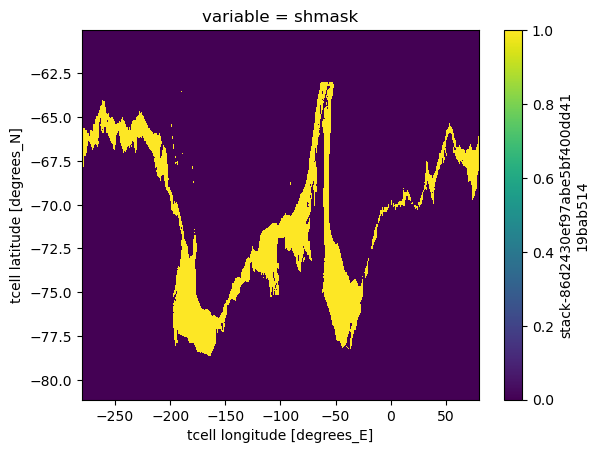

In [170]:
#mask shelf regions
shmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
shmask = shmask.where(~xr.ufuncs.isfinite(shmask.where(ht.yt_ocean>-63)))
shmask = ~xr.ufuncs.isnan(shmask).to_dataset(name='shmask')
sharea=area_t.where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()

shmask=shmask.to_array()
shmask.plot()

(640,)


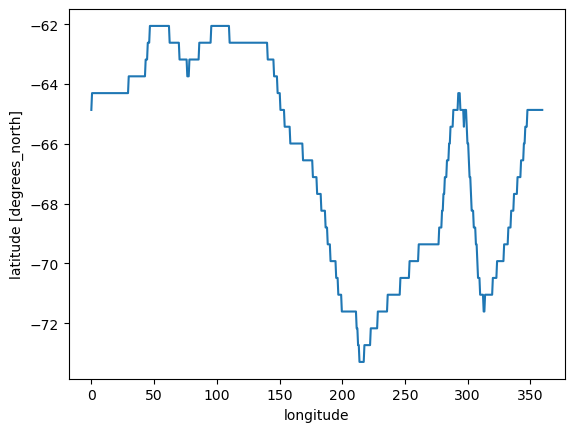

In [171]:
#make 0 windspeed area mask
#this is from windspeed input on jra grid 320 x640 - from fig. 1
fi = '/home/561/pas561/gdv45/jnb/easterlies-collaborative-project/notebooks/figures/tx0_smoothed.nc'
tx0 = xr.open_dataset(fi, decode_times = False).latitude[1:]
print(tx0.latitude.shape)
tx0.latitude.plot()

In [172]:
#regrid from jra to yt_ocean: 641 to 3600
#first change longitude from 0:360 to -280:80
#for 0-360
tx0['_lon_adj'] = xr.where(tx0['longitude'] > 80, tx0['longitude'] - 360, tx0['longitude'])

tx0 = tx0.swap_dims({'longitude': '_lon_adj'})
tx0 = tx0.sel(**{'_lon_adj': sorted(tx0._lon_adj)}).drop('longitude')
tx0 = tx0.rename({'_lon_adj': 'longitude'})

#now regrid it to xu_ocean
tx0_01=tx0.interp(longitude=xt_ocean)

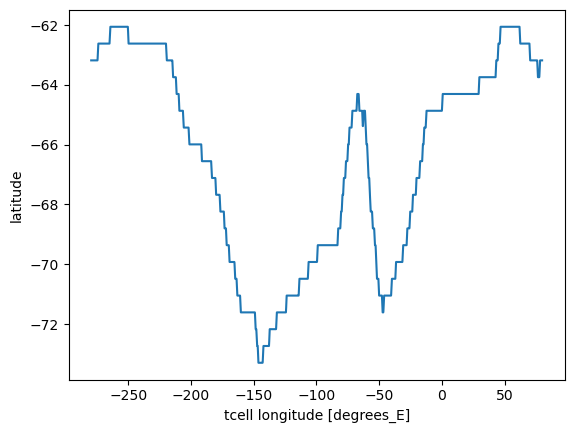

In [173]:
tx0_01.latitude.plot()

In [174]:
#mask tx=0 region
tx0mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht.yt_ocean>tx0_01.latitude)))
tx0mask = ~xr.ufuncs.isnan(tx0mask).to_dataset(name='tx0mask')
tx0area=area_t.where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()


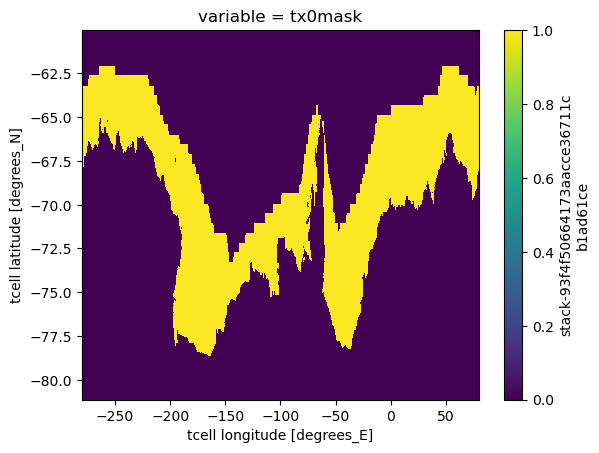

In [175]:
tx0mask=tx0mask.to_array()
tx0mask.plot()

In [176]:
tx0mask

<xarray.DataArray 'stack-93f4f50664173aacce36711cb1ad61ce' (variable: 1, yt_ocean: 490, xt_ocean: 3600)>
dask.array<stack, shape=(1, 490, 3600), dtype=bool, chunksize=(1, 490, 900), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 900), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 900), meta=np.ndarray>
    latitude   (xt_ocean) float64 nan nan nan nan ... -63.18 -63.18 -63.18 nan
    longitude  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * variable   (variable) <U7 'tx0mask'

In [177]:
#mask tx=0 region and ht>1000
tx0mask2 = ht.where(~xr.ufuncs.isfinite(ht.where(ht<1000)))
tx0mask2 = tx0mask2.where(~xr.ufuncs.isfinite(tx0mask2.where(ht.yt_ocean>tx0_01.latitude)))

tx0mask2 = ~xr.ufuncs.isnan(tx0mask2).to_dataset(name='tx0mask2')
tx0area2=area_t.where(tx0mask2).sum(dim=('xt_ocean','yt_ocean')).compute()


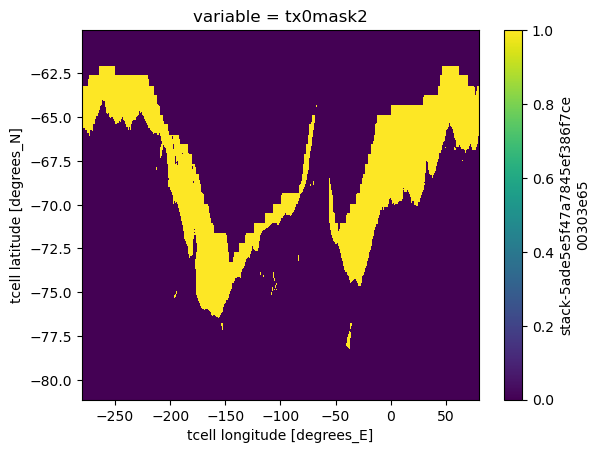

In [178]:
tx0mask2=tx0mask2.to_array()
tx0mask2.plot()

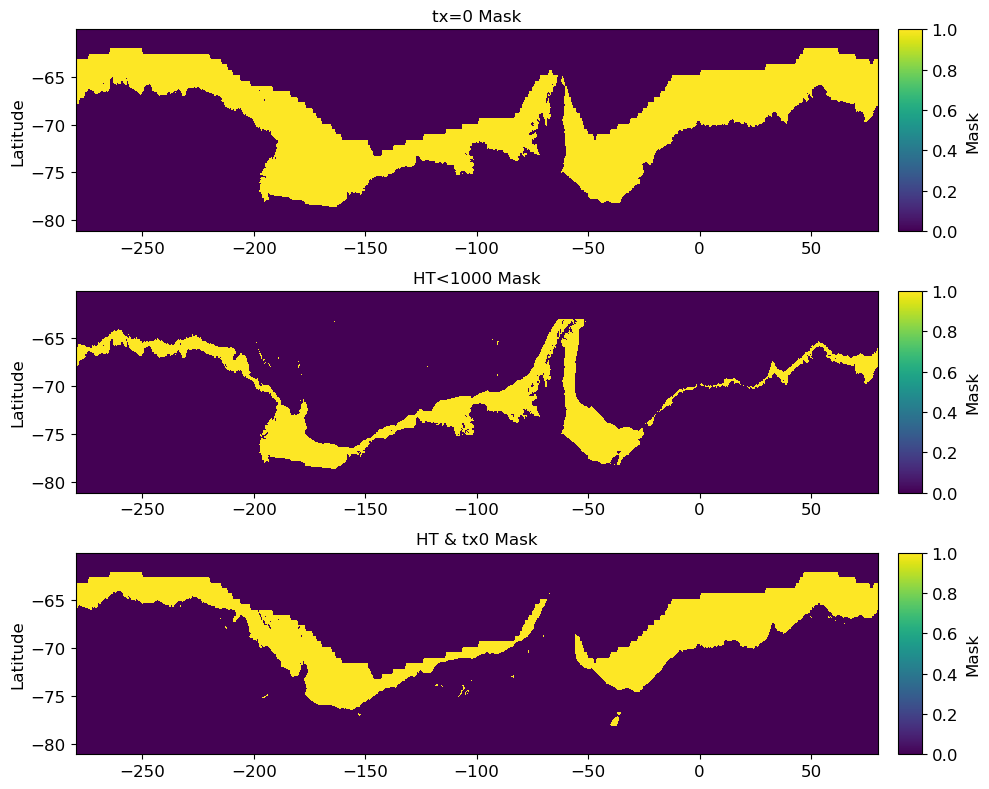

In [179]:
fontsize=12

ax=plt.figure(figsize=(10,8))
#ax.patch.set_color('.5')

plt.subplot(3,1,1)
plt.title('tx=0 Mask',fontsize=fontsize)
pc=plt.pcolormesh(tx0mask.xt_ocean,tx0mask.yt_ocean,tx0mask[0],vmin=0,vmax=1)
#plt.ylim(-75.5,-71)
#plt.xlim(-140,-100)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Mask',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,2)
plt.title('HT<1000 Mask',fontsize=fontsize)
#pc=plt.pcolormesh(tx0mask.xt_ocean,tx0mask.yt_ocean,tx0mask[0],vmin=0,vmax=1)
pc=plt.pcolormesh(shmask.xt_ocean,shmask.yt_ocean,shmask[0],vmin=0,vmax=1)
#plt.ylim(-75.5,-71)
#plt.xlim(-140,-100)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Mask',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.subplot(3,1,3)
plt.title('HT & tx0 Mask',fontsize=fontsize)
pc=plt.pcolormesh(tx0mask2.xt_ocean,tx0mask2.yt_ocean,tx0mask2[0],vmin=0,vmax=1)
#plt.ylim(-75.5,-71)
#plt.xlim(-140,-100)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Mask',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

In [180]:
# last 5 years of simulation:
start_time='2155-01-01'
end_time='2159-12-31'
#end_time='2150-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-59.0) #-50.04-

In [181]:
ekman_con=xr.open_dataset('ekmanpump_control_sigma02155-2159.nc').mean(dim='year')
ekman_up=xr.open_dataset('ekmanpump_up_sigma02155-2159.nc').mean(dim='year')
ekman_down=xr.open_dataset('ekmanpump_down_sigma02155-2159.nc').mean(dim='year')

In [182]:
ekman_upz=xr.open_dataset('ekmanpump_up_sigma0d_dy_tauxf2155-2159.nc').mean(dim='year')*-1
ekman_upm=xr.open_dataset('ekmanpump_up_sigma0d_dx_tauyf2155-2159.nc').mean(dim='year')

In [183]:
ekman_upz

<xarray.Dataset>
Dimensions:         (isopycnal_bins: 82, xt_ocean: 3600, yt_ocean: 490)
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 25.02 25.08 25.12 ... 29.03 29.08
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.1 -60.05
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
Data variables:
    ekman_sigma0    (isopycnal_bins, yt_ocean, xt_ocean) float64 nan nan ... nan

# area integrate per rho class

In [184]:
ekman_con_aint=(ekman_con.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_aint=(ekman_up.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upz_aint=(ekman_upz.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upm_aint=(ekman_upm.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_aint=(ekman_down.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()

In [185]:
#ekman_con_coast_aint=(ekman_control.ekman_sigma0.mean(dim='year')*area_t).where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()
#ekman_up_coast_aint=(ekman_up.ekman_sigma0.mean(dim='year')*area_t).where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()
#ekman_down_coast_aint=(ekman_down.ekman_sigma0.mean(dim='year')*area_t).where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()

In [186]:
ekman_con_shelf_aint=(ekman_con.ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_shelf_aint=(ekman_up.ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upz_shelf_aint=(ekman_upz.ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upm_shelf_aint=(ekman_upm.ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_shelf_aint=(ekman_down.ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

In [187]:
ekman_con_tx0_aint=(ekman_con.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_tx0_aint=(ekman_up.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upz_tx0_aint=(ekman_upz.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upm_tx0_aint=(ekman_upm.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_tx0_aint=(ekman_down.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

In [188]:
ekman_con_tx02_aint=(ekman_con.ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_tx02_aint=(ekman_up.ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upz_tx02_aint=(ekman_upz.ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upm_tx02_aint=(ekman_upm.ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_tx02_aint=(ekman_down.ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

In [189]:
ekman_up_aint

<xarray.DataArray (isopycnal_bins: 82)>
array([-5.00548638e+09, -5.44131196e+09, -5.95488112e+09, -6.25776956e+09,
       -5.94451132e+09, -6.88430002e+09, -6.86704297e+09, -7.77329098e+09,
       -7.94773121e+09, -8.38817245e+09, -7.70453064e+09, -7.46047590e+09,
       -8.00042327e+09, -7.91432506e+09, -8.30972338e+09, -7.85312658e+09,
       -7.30595182e+09, -6.68509840e+09, -5.87457585e+09, -4.62316986e+09,
       -5.09151941e+09, -4.33420615e+09, -3.14580046e+09, -1.14423033e+09,
        5.59432187e+08,  1.92543987e+09,  3.24005012e+09,  2.48586471e+09,
        1.75710752e+09,  2.82091625e+09,  1.17244176e+09,  3.76252407e+09,
        9.19369146e+09,  1.56192607e+10,  1.83850173e+10,  2.41670061e+10,
        3.54389902e+10,  5.51694738e+10,  8.22544090e+10,  1.10679746e+11,
        1.20320641e+11,  1.32389756e+11,  1.44456383e+11,  1.49105538e+11,
        1.54579889e+11,  1.75982369e+11,  1.72050763e+11,  1.44441227e+11,
        1.15391406e+11,  1.01262139e+11,  8.81816536e+10,  7.20806098e+10,
        6.31699084e+10,  3.41195784e+10,  1.84714245e+10, -3.40626807e+10,
       -4.41344821e+10, -3.71036551e+10, -2.38086942e+10, -1.71413474e+10,
       -1.38697515e+10, -1.04106569e+10, -5.18688070e+09, -2.73136039e+09,
       -1.95424613e+09, -7.41870109e+08, -2.32157512e+08, -5.31371241e+08,
       -6.25530046e+08, -4.99134632e+08, -2.92800152e+08, -2.03092669e+07,
       -1.79211744e+08, -1.98185767e+08, -6.66443865e+07,  3.09100919e+06,
        1.63485849e+08,  1.54185763e+08,  1.25965096e+08,  6.28213115e+07,
       -6.24731852e+07,  2.55855379e+07])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 25.02 25.08 25.12 ... 29.03 29.08

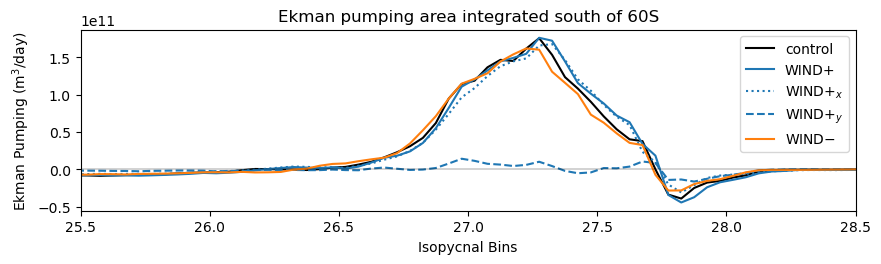

In [191]:
fontsize=12

plt.figure(figsize=(10,8))


plt.subplot(311)
plt.plot(ekman_con.isopycnal_bins,ekman_con_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_con_aint-ekman_con_aint,linestyle='-',color='k',linewidth=0.25)
plt.xlim((25.5,28.5))
#plt.ylim((-1e11,1.1e11))
plt.ylabel('Ekman Pumping (m$^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman pumping area integrated south of 60S')
plt.legend(fontsize=10, loc="upper right")

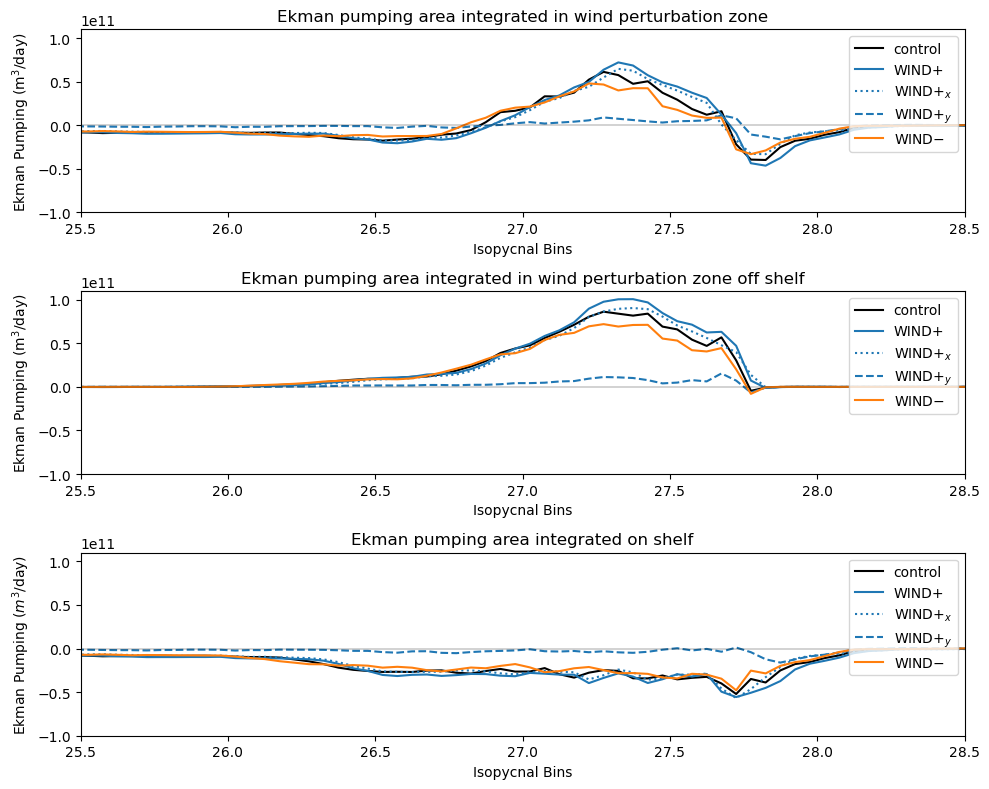

In [126]:
fontsize=12

plt.figure(figsize=(10,8))


plt.subplot(311)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_tx0_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_tx0_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_tx0_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_tx0_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint-ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
plt.xlim((25.5,28.5))
plt.ylim((-1e11,1.1e11))
plt.ylabel('Ekman Pumping (m$^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman pumping area integrated in wind perturbation zone')
plt.legend(fontsize=10, loc="upper right")

plt.subplot(312)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx02_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_tx02_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_tx02_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_tx02_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_tx02_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint-ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylim((-1e11,1.1e11))
plt.ylabel('Ekman Pumping (m$^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman pumping area integrated in wind perturbation zone off shelf')
plt.legend(fontsize=10, loc="upper right")

plt.subplot(313)
plt.plot(ekman_con.isopycnal_bins,ekman_con_shelf_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_shelf_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_shelf_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_shelf_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_shelf_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint-ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylim((-1e11,1.1e11))
plt.ylabel('Ekman Pumping ($m^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman pumping area integrated on shelf')
plt.legend(fontsize=10, loc="upper right")


plt.tight_layout()

## plot zonal average rho and temp to identify CDW classes

In [127]:
# Surface density:
pot_rho_0 = cc.querying.getvar(expt, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean(dim='time') #.resample({'time':'Y'}).mean('time')
pot_rho_0

<xarray.DataArray 'pot_rho_0' (st_ocean: 75, yt_ocean: 510, xt_ocean: 3600)>
dask.array<mean_agg-aggregate, shape=(75, 510, 3600), dtype=float32, chunksize=(7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.14 -59.08 -59.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [128]:
temp = cc.querying.getvar(expt, 'temp', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) -273.13
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean(dim='time') #.resample({'time':'Y'}).mean('time')
temp

<xarray.DataArray 'temp' (st_ocean: 75, yt_ocean: 510, xt_ocean: 3600)>
dask.array<mean_agg-aggregate, shape=(75, 510, 3600), dtype=float32, chunksize=(7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.14 -59.08 -59.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

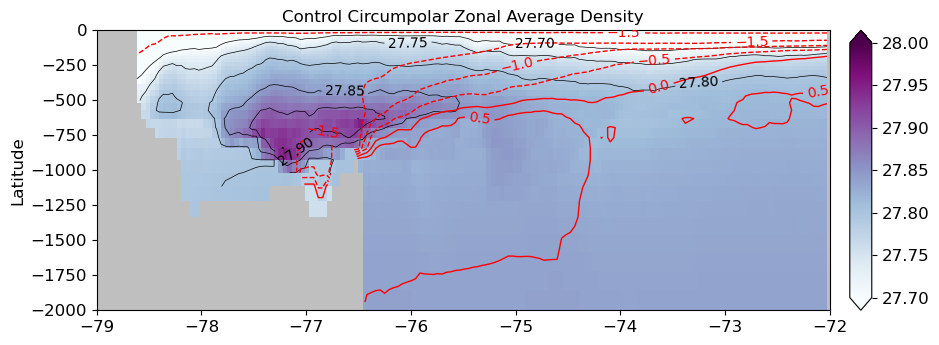

In [129]:
fontsize=12
levels=np.arange(27.7, 28., 0.05)
levels2=np.arange(-2, 6, 0.5)

#needed for clabels
lat_slice=slice(-79,-72)
rho=pot_rho_0.sel(yt_ocean=lat_slice).mean(dim='xt_ocean').compute()
t=temp.sel(yt_ocean=lat_slice).mean(dim='xt_ocean').compute()


plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.title('Control Circumpolar Zonal Average Density',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.xlim(-79,-72)
plt.ylim(-2000,0)
#plt.xlim(-140,-100)

p1=plt.pcolormesh(rho.yt_ocean,-rho.st_ocean,rho,vmin=levels[0],vmax=levels[-1],cmap=plt.cm.BuPu)
pr=plt.contour(rho.yt_ocean,-rho.st_ocean,rho,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)

pr2=plt.contour(t.yt_ocean,-t.st_ocean,t,levels=levels2,colors='r',linewidths=1)
plt.clabel(pr2, pr2.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

In [130]:
#Amundsen Region plt.xlim(-140,-100)
lon_slice=slice(-120,-100)

AS_ekman_con_shelf_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_up_shelf_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_upz_shelf_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_upm_shelf_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_down_shelf_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

In [131]:
AS_ekman_con_tx0_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_up_tx0_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_upz_tx0_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_upm_tx0_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_down_tx0_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

In [132]:
AS_ekman_con_tx02_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_up_tx02_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_upz_tx02_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_upm_tx02_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_down_tx02_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

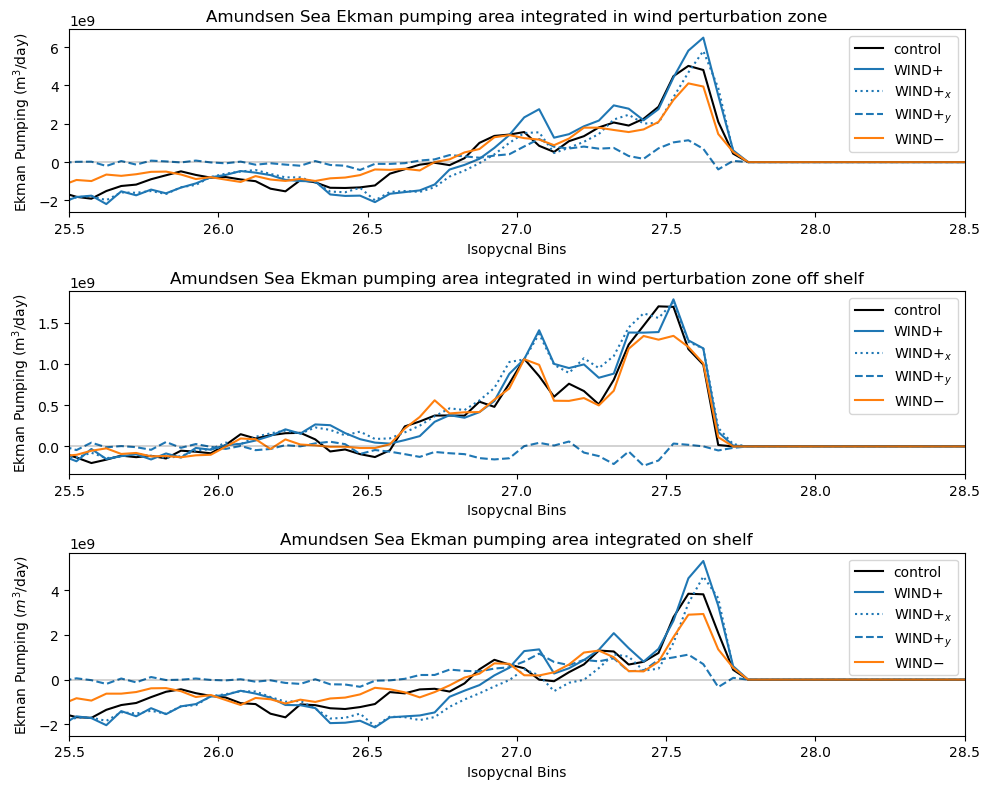

In [133]:
fontsize=12

plt.figure(figsize=(10,8))


plt.subplot(311)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_con_tx0_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_up_tx0_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_upz_tx0_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_upm_tx0_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_down_tx0_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_con_tx0_aint-AS_ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
plt.xlim((25.5,28.5))
#plt.ylim((-1e11,1.1e11))
plt.ylabel('Ekman Pumping (m$^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Amundsen Sea Ekman pumping area integrated in wind perturbation zone')
plt.legend(fontsize=10, loc="upper right")

plt.subplot(312)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_con_tx02_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_up_tx02_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_upz_tx02_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_upm_tx02_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_down_tx02_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_con_tx0_aint-AS_ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
#plt.ylim((-1e11,1.1e11))
plt.ylabel('Ekman Pumping (m$^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Amundsen Sea Ekman pumping area integrated in wind perturbation zone off shelf')
plt.legend(fontsize=10, loc="upper right")

plt.subplot(313)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_con_shelf_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_up_shelf_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_upz_shelf_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_upm_shelf_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_down_shelf_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_con_tx0_aint-AS_ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
#plt.ylim((-1e11,1.1e11))
plt.ylabel('Ekman Pumping ($m^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Amundsen Sea Ekman pumping area integrated on shelf')
plt.legend(fontsize=10, loc="upper right")


plt.tight_layout()

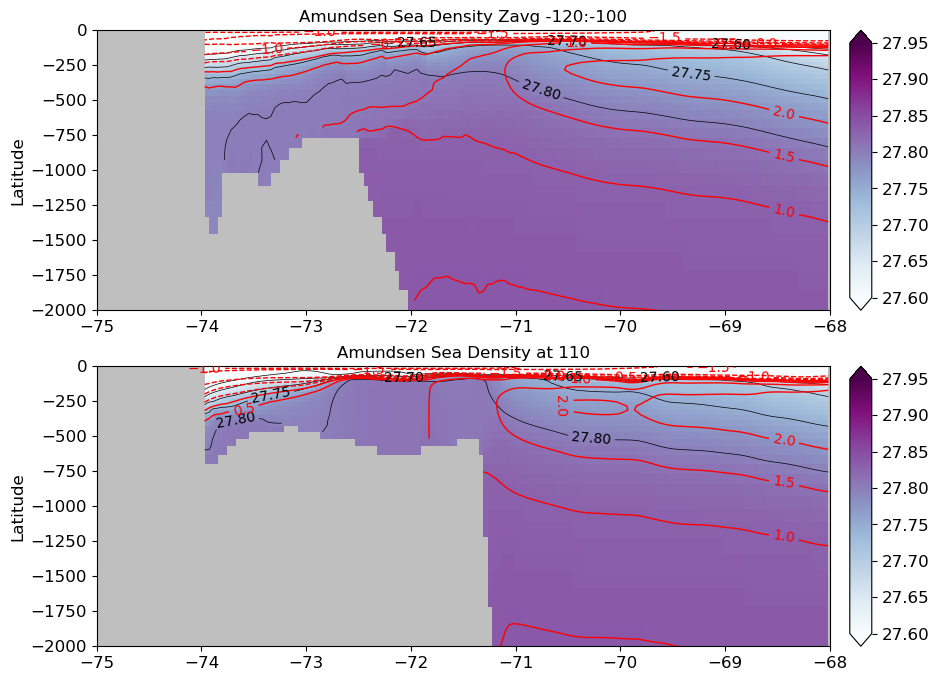

In [134]:
fontsize=12
levels=np.arange(27.6, 28, 0.05)
levels2=np.arange(-2, 6, 0.5)

lon_slice=slice(-120,-100)
lat_slice=slice(-74,-68)

#needed for clabels
rho=pot_rho_0.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()
t=temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.title('Amundsen Sea Density Zavg -120:-100',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.xlim(-75,-68)
plt.ylim(-2000,0)
#plt.xlim(-140,-100)

p1=plt.pcolormesh(rho.yt_ocean,-rho.st_ocean,rho,vmin=levels[0],vmax=levels[-1],cmap=plt.cm.BuPu)
pr=plt.contour(rho.yt_ocean,-rho.st_ocean,rho,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)

pr2=plt.contour(t.yt_ocean,-t.st_ocean,t,levels=levels2,colors='r',linewidths=1)
plt.clabel(pr2, pr2.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


lon_slice=slice(-112,-110)
#needed for clabels
rho=pot_rho_0.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()
t=temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()

plt.subplot(2,1,2)
plt.title('Amundsen Sea Density at 110',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.xlim(-75,-68)
plt.ylim(-2000,0)
#plt.xlim(-140,-100)

p1=plt.pcolormesh(rho.yt_ocean,-rho.st_ocean,rho,vmin=levels[0],vmax=levels[-1],cmap=plt.cm.BuPu)
pr=plt.contour(rho.yt_ocean,-rho.st_ocean,rho,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)

pr2=plt.contour(t.yt_ocean,-t.st_ocean,t,levels=levels2,colors='r',linewidths=1)
plt.clabel(pr2, pr2.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

In [135]:
#Denman Region
lon_slice=slice(-270,-250)

DM_ekman_con_shelf_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_up_shelf_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_upz_shelf_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_upm_shelf_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_down_shelf_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

In [136]:
DM_ekman_con_tx0_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_up_tx0_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_upz_tx0_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_upm_tx0_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_down_tx0_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

In [137]:
DM_ekman_con_tx02_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_up_tx02_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_upz_tx02_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_upm_tx02_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_down_tx02_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

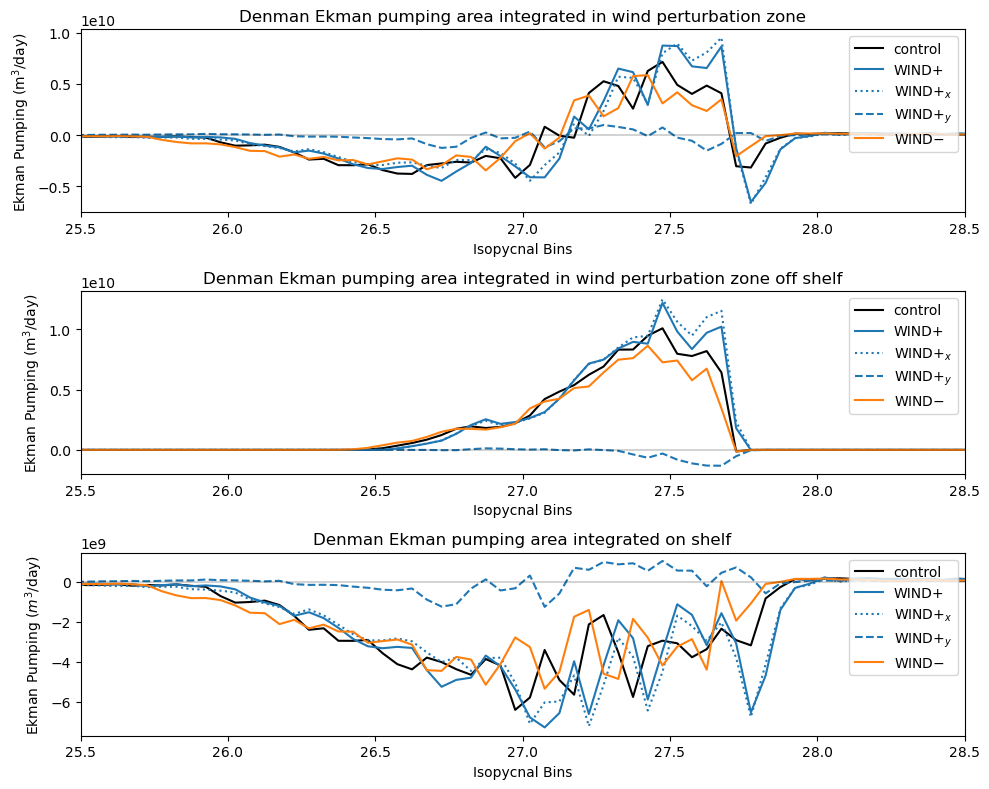

In [138]:
fontsize=12

plt.figure(figsize=(10,8))


plt.subplot(311)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_con_tx0_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_up_tx0_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_upz_tx0_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_upm_tx0_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_down_tx0_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_con_tx0_aint-DM_ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
plt.xlim((25.5,28.5))
#plt.ylim((-1e11,1.1e11))
plt.ylabel('Ekman Pumping (m$^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Denman Ekman pumping area integrated in wind perturbation zone')
plt.legend(fontsize=10, loc="upper right")

plt.subplot(312)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_con_tx02_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_up_tx02_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_upz_tx02_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_upm_tx02_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_down_tx02_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_con_tx0_aint-DM_ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
#plt.ylim((-1e11,1.1e11))
plt.ylabel('Ekman Pumping (m$^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Denman Ekman pumping area integrated in wind perturbation zone off shelf')
plt.legend(fontsize=10, loc="upper right")

plt.subplot(313)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_con_shelf_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_up_shelf_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_upz_shelf_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_upm_shelf_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_down_shelf_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_con_tx0_aint-DM_ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
#plt.ylim((-1e11,1.1e11))
plt.ylabel('Ekman Pumping ($m^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Denman Ekman pumping area integrated on shelf')
plt.legend(fontsize=10, loc="upper right")


plt.tight_layout()

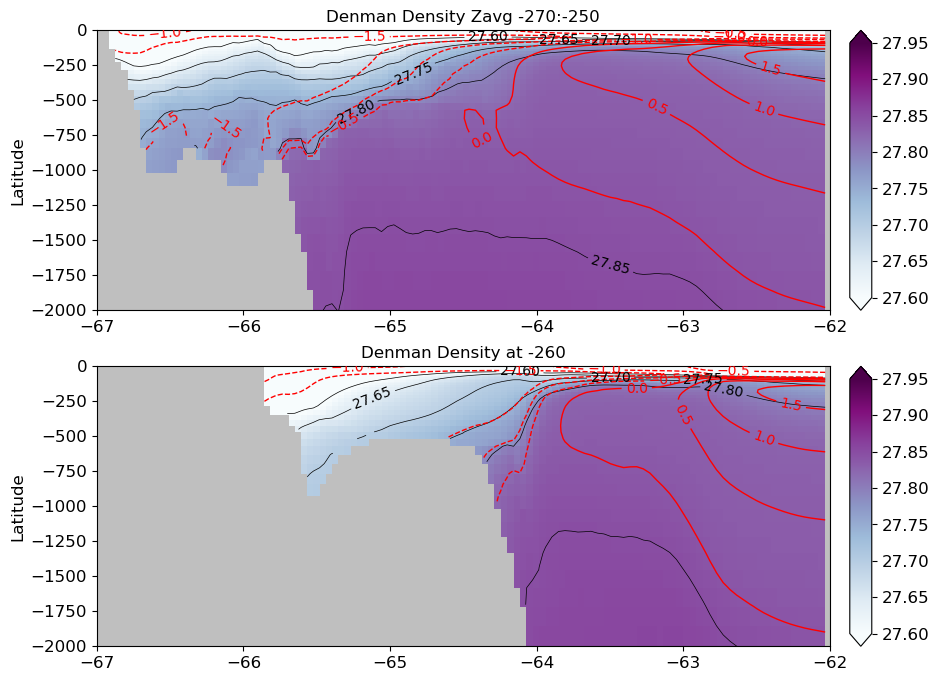

In [139]:
fontsize=12
levels=np.arange(27.6, 28, 0.05)
levels2=np.arange(-2, 6, 0.5)

lon_slice=slice(-270,-250)
lat_slice=slice(-67,-62)

#needed for clabels
rho=pot_rho_0.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()
t=temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.title('Denman Density Zavg -270:-250',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.xlim(-67,-62)
plt.ylim(-2000,0)
#plt.xlim(-140,-100)

p1=plt.pcolormesh(rho.yt_ocean,-rho.st_ocean,rho,vmin=levels[0],vmax=levels[-1],cmap=plt.cm.BuPu)
pr=plt.contour(rho.yt_ocean,-rho.st_ocean,rho,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)

pr2=plt.contour(t.yt_ocean,-t.st_ocean,t,levels=levels2,colors='r',linewidths=1)
plt.clabel(pr2, pr2.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


lon_slice=slice(-262,-260)
#needed for clabels
rho=pot_rho_0.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()
t=temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()

plt.subplot(2,1,2)
plt.title('Denman Density at -260',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.xlim(-67,-62)
plt.ylim(-2000,0)
#plt.xlim(-140,-100)

p1=plt.pcolormesh(rho.yt_ocean,-rho.st_ocean,rho,vmin=levels[0],vmax=levels[-1],cmap=plt.cm.BuPu)
pr=plt.contour(rho.yt_ocean,-rho.st_ocean,rho,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)

pr2=plt.contour(t.yt_ocean,-t.st_ocean,t,levels=levels2,colors='r',linewidths=1)
plt.clabel(pr2, pr2.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

In [142]:
#weddell Region
lon_slice=slice(-50,-30)

WS_ekman_con_shelf_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_up_shelf_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_upz_shelf_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_upm_shelf_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_down_shelf_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

In [143]:
WS_ekman_con_tx0_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_up_tx0_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_upz_tx0_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_upm_tx0_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_down_tx0_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

In [144]:
WS_ekman_con_tx02_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_up_tx02_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_upz_tx02_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_upm_tx02_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_down_tx02_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

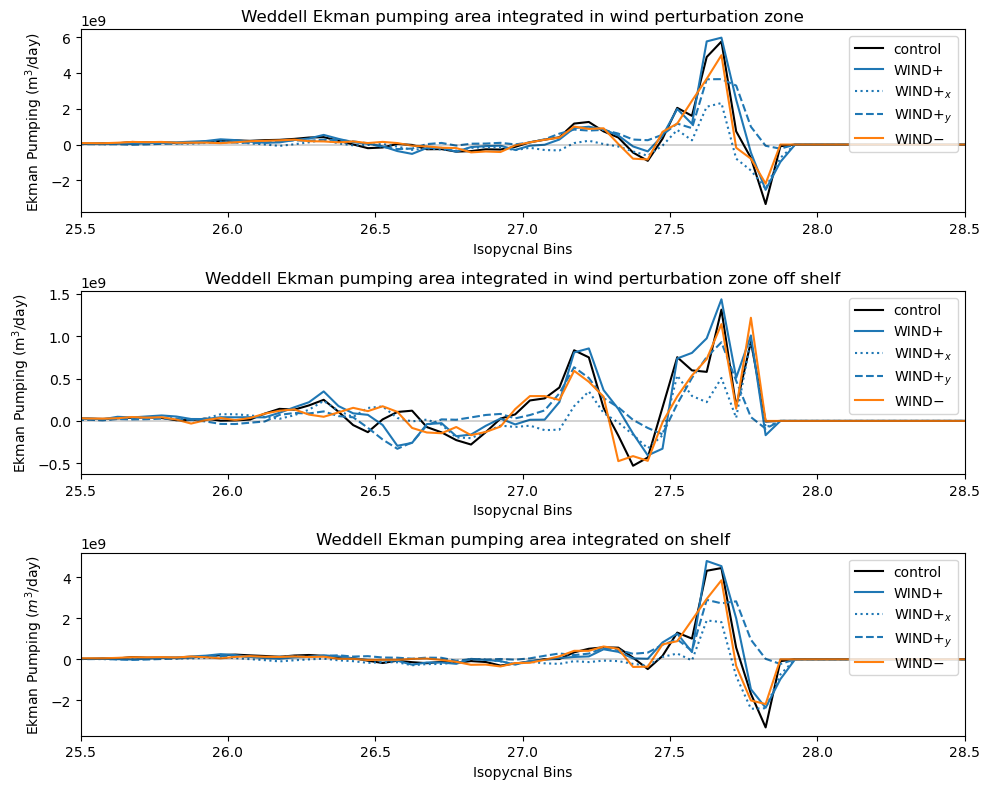

In [151]:
fontsize=12

plt.figure(figsize=(10,8))


plt.subplot(311)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_con_tx0_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_up_tx0_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_upz_tx0_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_upm_tx0_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_down_tx0_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_con_tx0_aint-WS_ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
plt.xlim((25.5,28.5))
#plt.ylim((-1e11,1.1e11))
plt.ylabel('Ekman Pumping (m$^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Weddell Ekman pumping area integrated in wind perturbation zone')
plt.legend(fontsize=10, loc="upper right")

plt.subplot(312)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_con_tx02_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_up_tx02_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_upz_tx02_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_upm_tx02_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_down_tx02_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_con_tx0_aint-WS_ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
#plt.ylim((-1e11,1.1e11))
plt.ylabel('Ekman Pumping (m$^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Weddell Ekman pumping area integrated in wind perturbation zone off shelf')
plt.legend(fontsize=10, loc="upper right")

plt.subplot(313)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_con_shelf_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_up_shelf_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_upz_shelf_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_upm_shelf_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_down_shelf_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_con_tx0_aint-WS_ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
#plt.ylim((-1e11,1.1e11))
plt.ylabel('Ekman Pumping ($m^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Weddell Ekman pumping area integrated on shelf')
plt.legend(fontsize=10, loc="upper right")


plt.tight_layout()

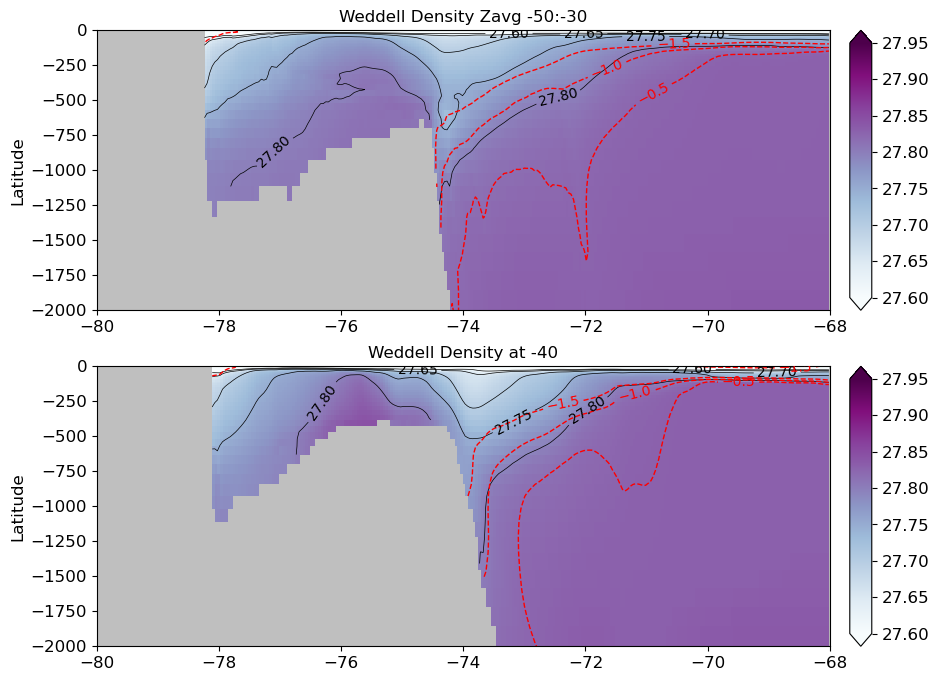

In [154]:
fontsize=12
levels=np.arange(27.6, 28, 0.05)
levels2=np.arange(-2, 6, 0.5)

lon_slice=slice(-50,-30)
lat_slice=slice(-80,-68)

#needed for clabels
rho=pot_rho_0.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()
t=temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.title('Weddell Density Zavg -50:-30',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.xlim(-80,-68)
plt.ylim(-2000,0)
#plt.xlim(-140,-100)

p1=plt.pcolormesh(rho.yt_ocean,-rho.st_ocean,rho,vmin=levels[0],vmax=levels[-1],cmap=plt.cm.BuPu)
pr=plt.contour(rho.yt_ocean,-rho.st_ocean,rho,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)

pr2=plt.contour(t.yt_ocean,-t.st_ocean,t,levels=levels2,colors='r',linewidths=1)
plt.clabel(pr2, pr2.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


lon_slice=slice(-42,-40)
#needed for clabels
rho=pot_rho_0.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()
t=temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()

plt.subplot(2,1,2)
plt.title('Weddell Density at -40',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.xlim(-80,-68)
plt.ylim(-2000,0)
#plt.xlim(-140,-100)

p1=plt.pcolormesh(rho.yt_ocean,-rho.st_ocean,rho,vmin=levels[0],vmax=levels[-1],cmap=plt.cm.BuPu)
pr=plt.contour(rho.yt_ocean,-rho.st_ocean,rho,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)

pr2=plt.contour(t.yt_ocean,-t.st_ocean,t,levels=levels2,colors='r',linewidths=1)
plt.clabel(pr2, pr2.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)